# On October 16, 2021 I changed all of these to JJA 19850-1869
# On October 20, 2021 I changed all of these to annual

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
# import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")


# `gn` datasets

1. retrieve datasets
2. preprocess
3. merge variables
4. filter for datasets that have all variables 
5. combine datasets + select first ensemble member

In [3]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gn = merge_variables(dd_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())
# dd_new_new_gn


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r2i1p1f2.Omon.gn.none.thetao failed to combine with :cannot compare cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) (different calendars)
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r10i1p1f1.Omon.gn.none.dissic failed to combine with :cannot compare cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0) (different calendars)
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Om

['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [4]:
# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item).assign_coords(**newcoords).chunk({'time':120,'lev':1})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply

['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

# `gr` datasets

In [3]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)

temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp
# list(dd_new_gr.keys())

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2.historical.r10i1p1f1.Omon.gr.none.fgco2 failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r3i1p1f1.Omon.gr.none.dissic failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r2i1p1f1.Omon.gr.none.so failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/po

['GFDL-ESM4.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon']

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


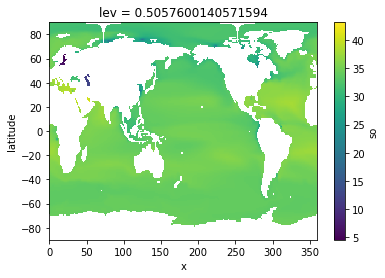

In [9]:
dd_regrid['UKESM1-0-LL.gn.historical.Omon'].so.isel(time = slice(0,239)).mean('time',keep_attrs=True).isel(lev = 0).plot()

# Save data

In [5]:
ds = dd_regrid['UKESM1-0-LL.gn.historical.Omon'].isel(time = slice(0,239))

# ds.dissic.sel(time=ds.time.dt.season=="JJA").mean('time',keep_attrs=True).to_netcdf('UKESM1_dissic_20yr.nc')
ds.dissic.mean('time',keep_attrs=True).to_netcdf('UKESM1_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('UKESM1_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('UKESM1_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('UKESM1_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('UKESM1_fgco2_20yr.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [6]:
ds = dd_regrid['IPSL-CM6A-LR.gn.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('IPSL_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('IPSL_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('IPSL_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('IPSL_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('IPSL_fgco2_20yr.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [7]:
ds = dd_regrid['CNRM-ESM2-1.gn.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('CNRM_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('CNRM_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('CNRM_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('CNRM_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('CNRM_fgco2_20yr.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [8]:
ds = dd_regrid['CanESM5-CanOE.gn.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('CanESM5CanOE_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('CanESM5CanOE_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('CanESM5CanOE_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('CanESM5CanOE_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('CanESM5CanOE_fgco2_20yr.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [9]:
ds = dd_regrid['CanESM5.gn.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('CanESM5_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('CanESM5_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('CanESM5_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('CanESM5_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('CanESM5_fgco2_20yr.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
ds.dissic.isel(time = slice(0,239)).mean('time',keep_attrs=True).nbytes/1e6

In [4]:
ds= dd_gr['CESM2-FV2.gr.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('CESM2-FV2_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('CESM2-FV2_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('CESM2-FV2_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('CESM2-FV2_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('CESM2-FV2_fgco2_20yr.nc')

In [5]:
ds= dd_gr['CESM2-WACCM-FV2.gr.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM-FV2_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM-FV2_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM-FV2_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM-FV2_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM-FV2_fgco2_20yr.nc')

In [6]:
ds= dd_gr['CESM2-WACCM.gr.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('CESM2-WACCM_fgco2_20yr.nc')

In [7]:
ds= dd_gr['CESM2.gr.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('CESM2_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('CESM2_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('CESM2_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('CESM2_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('CESM2_fgco2_20yr.nc')

In [8]:
ds= dd_gr['GFDL-CM4.gr.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('GFDL-CM4_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('GFDL-CM4_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('GFDL-CM4_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('GFDL-CM4_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('GFDL-CM4_fgco2_20yr.nc')

In [9]:
ds= dd_gr['GFDL-ESM4.gr.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('GFDL-ESM4_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('GFDL-ESM4_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('GFDL-ESM4_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('GFDL-ESM4_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('GFDL-ESM4_fgco2_20yr.nc')

In [10]:
ds= dd_gr['MRI-ESM2-0.gr.historical.Omon'].isel(time = slice(0,239))
ds.dissic.mean('time',keep_attrs=True).to_netcdf('MRI-ESM2-0_dissic_20yr.nc')
ds.talk.mean('time',keep_attrs=True).to_netcdf('MRI-ESM2-0_talk_20yr.nc')
ds.thetao.mean('time',keep_attrs=True).to_netcdf('MRI-ESM2-0_thetao_20yr.nc')
ds.so.mean('time',keep_attrs=True).to_netcdf('MRI-ESM2-0_so_20yr.nc')
ds.fgco2.mean('time',keep_attrs=True).to_netcdf('MRI-ESM2-0_fgco2_20yr.nc')

In [19]:
density = {}
for name, ds in dd.items():
    density[name] = gsw.sigma2(ds.so.isel(time = slice(0,239)).mean('time',keep_attrs=True),ds.thetao.isel(time = slice(0,239)).mean('time',keep_attrs=True))

In [20]:
density['CESM2-FV2.gr.historical.Omon']

<xarray.DataArray 'so' (lev: 33, y: 180, x: 360)>
dask.array<sigma2, shape=(33, 180, 360), dtype=float64, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes: (12/18)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Sea water salinity is the salt content of sea water, ofte...
    frequency:      mon
    id:             so
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Salinity
    type:           real
    variable_id:    so

# Areacello and GFDL debug

In [5]:

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4',
                         'GFDL-CM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gfdl = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gfdl = merge_variables(dd_gfdl)

temp={}
for name,item in dd_gfdl.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gfdl = temp
# list(dd_new_gr.keys())

dd_gfdl = combine_datasets(
    dd_gfdl,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gfdl.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-CM4.gr.historical.Omon', 'GFDL-ESM4.gr.historical.Omon']

In [16]:
PCO2 = {}

for name, ds in dd_gfdl.items():
    ds = ds.isel(time = slice(0,239), x=slice(180,200)).mean(['time', 'x'],keep_attrs=True)
    conversion =  1e6/1035
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
#      = results['pCO2_out']
    PCO2[name]=ds.dissic.copy(data=results['pCO2_out'])

In [7]:
var = ['areacello']
# 'areacello', 
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=var,
             grid_label=['gr'],
              source_id=['GFDL-ESM4',
                          
                         'GFDL-CM4']
            )
cat = col.search(**query)

dd_area_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

list(dd_area_gr.keys())

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_area_gr = combine_datasets(
    dd_area_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)

list(dd_area_gr.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

In [10]:
A = dd_area_gr['GFDL-ESM4.gr.historical.Ofx'].isel(x=slice(180,200)).mean(['x'],keep_attrs=True)
A

<xarray.Dataset>
Dimensions:    (y: 180)
Coordinates:
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    areacello  (y) float32 dask.array<chunksize=(180,), meta=np.ndarray>
Attributes: (12/51)
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   36500.0
    comment:                 <null ref>
    ...                      ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/99c05a58-af12-4ba0-a5be-fb4a5cc74f0f
    version_id:              v20190726
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Ofx...

In [18]:
PCO2['GFDL-ESM4.gr.historical.Omon'].isel(lev = 15)*A.areacello

<xarray.DataArray (y: 180)>
dask.array<multiply, shape=(180,), dtype=float64, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    lev      float64 700.0

In [14]:
A.areacello

<xarray.DataArray 'areacello' (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    cell_methods:   area: sum
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m²

In [17]:
PCO2['GFDL-ESM4.gr.historical.Omon']

<xarray.DataArray 'dissic' (lev: 35, y: 180)>
array([[         nan,          nan,          nan, ..., 223.44228035,
        222.66073824, 222.20906642],
       [         nan,          nan,          nan, ..., 224.29274971,
        223.59054933, 223.48953765],
       [         nan,          nan,          nan, ..., 227.80764459,
        227.52920992, 228.24007368],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Dissolved Inorganic Carbon Concentration
    original_name:  dissic
    standard_name:  mole_concentration_of_dissolved_inorganic_carbon_in_sea_w...
    units:          mol/m³

In [22]:
dd_gfdl['GFDL-CM4.gr.historical.Omon'].fgco2.isel(time = slice(0,239)).mean(['time', 'x'],keep_attrs=True)*A.areacello

<xarray.DataArray (y: 180)>
dask.array<mul, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5